# Implementación Manual de K-Means para Ubicación Óptima de Hospitales

**Autor:** Duvan Santiago Matallana Jiménez - Laura Estefania Latorre Pachon  
**Objetivo:** Determinar la ubicación óptima de A hospitales en un universo plano usando K-Means implementado desde cero.
Universidad de Cundinamarca  
Machine Learning - Grupo 802  

---

## 1. Introducción al Problema

### Contexto del Problema

En este proyecto abordamos el siguiente problema de optimización:

- **Universo plano:** Un espacio bidimensional de dimensiones n × n que representa una región geográfica.
- **Vecindarios (M escenarios):** M puntos distribuidos de manera no simétrica en este universo, cada uno representa un vecindario o comunidad que requiere acceso a servicios hospitalarios.
- **Hospitales (A centros):** Necesitamos ubicar A hospitales de forma óptima para minimizar la distancia promedio de los vecindarios a su hospital más cercano.

### Variables Principales del Problema

El problema se define completamente con dos variables:

1. **M:** Número de vecindarios en el universo (puntos a agrupar)
2. **A:** Número de hospitales a ubicar (número de clusters K-Means)

Cada vecindario se representa únicamente por sus coordenadas (x, y) en el universo plano.

### Restricciones Técnicas

**Librerías permitidas:**
- `numpy`: Para operaciones matriciales y cálculos numéricos
- `pandas`: Para manejo de datos tabulares
- `matplotlib`: Para visualizaciones
- Librerías estándar de Python

**Librerías NO permitidas:**
- `scikit-learn` ni ninguna otra librería de machine learning
- El algoritmo K-Means debe implementarse completamente desde cero

### Objetivo del Clustering

Usaremos el algoritmo **K-Means** para:
1. Agrupar los M vecindarios en A clusters (grupos)
2. Cada cluster representa el área de cobertura de un hospital
3. El centroide de cada cluster indica la ubicación óptima para construir el hospital
4. Minimizar la suma de distancias cuadráticas (SSE) entre vecindarios y hospitales

### Capacidad Máxima

Cada hospital tiene una capacidad máxima de atender **1,000,000 × 1,000,000 = 1,000,000,000,000 vecindarios**, lo cual verificaremos al final del análisis.

In [48]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Semilla para reproducibilidad
np.random.seed(42)

print("Librerías importadas correctamente")
print(f"Versión de NumPy: {np.__version__}")
print(f"Versión de Pandas: {pd.__version__}")

Librerías importadas correctamente
Versión de NumPy: 2.1.3
Versión de Pandas: 2.2.3


## 2. Generación y Carga de Datos

En esta sección crearemos un dataset simulado que representa M vecindarios distribuidos en un universo plano.

### Características del Dataset

- **Coordenadas (x, y):** Posición de cada vecindario en el plano
- **Distribución:** No simétrica, con posibles zonas de alta densidad

### Variables del Problema

- **M:** Número de vecindarios en el universo
- **A:** Número de hospitales a ubicar (clusters K-Means)

In [ ]:
# ============================================
# PARÁMETROS PRINCIPALES DEL PROBLEMA
# ============================================
UNIVERSE_SIZE = 1000  # Universo de 1000x1000 unidades
M_VECINDARIOS = 500   # M: Número de vecindarios a generar
# A (número de hospitales) se determinará automáticamente o se puede especificar

def generar_vecindarios(n_vecindarios, universe_size, n_clusters_reales=5):
    """
    Genera vecindarios con distribución no uniforme simulando zonas urbanas.
    
    Parámetros:
    -----------
    n_vecindarios : int (M)
        Número de vecindarios a generar
    universe_size : int
        Tamaño del universo (n x n)
    n_clusters_reales : int
        Número de zonas de concentración
    
    Retorna:
    --------
    DataFrame con columnas: id_vecindario, x, y
    """
    vecindarios = []
    
    # Generar centros de zonas urbanas
    centros_urbanos = np.random.uniform(0, universe_size, (n_clusters_reales, 2))
    
    # Distribución de vecindarios por zona urbana
    vecindarios_por_zona = np.random.multinomial(
        n_vecindarios, 
        [1/n_clusters_reales] * n_clusters_reales
    )
    
    id_vecindario = 0
    
    for i, centro in enumerate(centros_urbanos):
        n_vec_zona = vecindarios_por_zona[i]
        
        # Generar vecindarios alrededor del centro con dispersión variable
        dispersion = np.random.uniform(50, 150)
        
        for _ in range(n_vec_zona):
            # Coordenadas con distribución normal alrededor del centro
            x = np.clip(np.random.normal(centro[0], dispersion), 0, universe_size)
            y = np.clip(np.random.normal(centro[1], dispersion), 0, universe_size)
            
            vecindarios.append({
                'id_vecindario': id_vecindario,
                'x': x,
                'y': y
            })
            
            id_vecindario += 1
    
    return pd.DataFrame(vecindarios)

# Generar dataset
df_vecindarios = generar_vecindarios(M_VECINDARIOS, UNIVERSE_SIZE)

print(f"Dataset generado con M = {len(df_vecindarios)} vecindarios")
print(f"\nPrimeras filas del dataset:")
print(df_vecindarios.head(10))
print(f"\nEstadísticas descriptivas:")
print(df_vecindarios.describe())

Dataset generado con M = 500 vecindarios

Primeras filas del dataset:
   id_vecindario           x            y
0              0  450.628311   808.697442
1              1  334.648579   881.526071
2              2  308.992344   751.313425
3              3  315.876513  1000.000000
4              4  613.070331   987.454657
5              5  385.930273   902.678537
6              6  318.599760  1000.000000
7              7  401.662888   891.483633
8              8  279.337071   935.639594
9              9  324.806984   950.199140

Estadísticas descriptivas:
       id_vecindario           x            y
count     500.000000  500.000000   500.000000
mean      249.500000  400.320795   643.747286
std       144.481833  272.707952   279.652165
min         0.000000    0.000000     0.000000
25%       124.750000  126.777078   562.947393
50%       249.500000  418.861518   676.874917
75%       374.250000  653.235422   865.071743
max       499.000000  853.355186  1000.000000


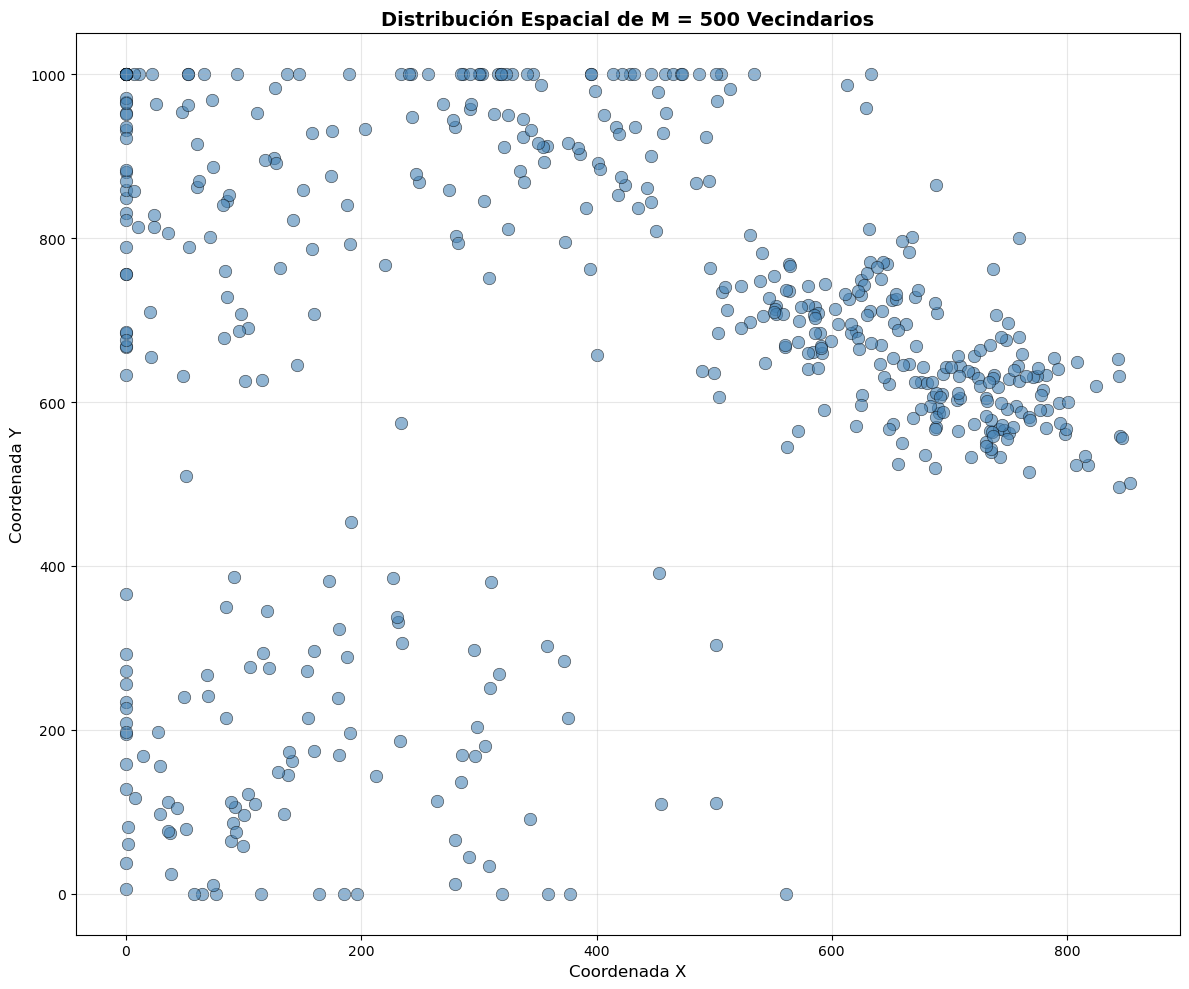


Total de vecindarios en el universo: 500


In [50]:
# Visualización de la distribución inicial de vecindarios
fig, ax = plt.subplots(figsize=(12, 10))

# Distribución espacial de vecindarios
ax.scatter(df_vecindarios['x'], df_vecindarios['y'], 
           alpha=0.6, s=80, c='steelblue', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Coordenada X', fontsize=12)
ax.set_ylabel('Coordenada Y', fontsize=12)
ax.set_title(f'Distribución Espacial de M = {M_VECINDARIOS} Vecindarios', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal de vecindarios en el universo: {len(df_vecindarios)}")

## 3. Implementación Manual de K-Means

Implementaremos el algoritmo K-Means desde cero siguiendo estos pasos:

### Algoritmo K-Means

1. **Inicialización:** Seleccionar K centroides iniciales aleatoriamente
2. **Asignación:** Asignar cada punto al centroide más cercano
3. **Actualización:** Recalcular centroides como el promedio de los puntos asignados
4. **Convergencia:** Repetir 2-3 hasta que los centroides no cambien significativamente

### Métricas

- **SSE (Sum of Squared Errors):** Suma de distancias cuadráticas de cada punto a su centroide
- **WSS (Within-Cluster Sum of Squares):** Sinónimo de SSE
- **Iteraciones:** Número de iteraciones hasta convergencia

In [51]:
def distancia_euclidiana(punto1, punto2):
    """
    Calcula la distancia euclidiana entre dos puntos.
    
    Parámetros:
    -----------
    punto1, punto2 : array-like
        Coordenadas de los puntos
    
    Retorna:
    --------
    float: Distancia euclidiana
    """
    return np.sqrt(np.sum((punto1 - punto2) ** 2))


def inicializar_centroides(X, k, metodo='random'):
    """
    Inicializa k centroides.
    
    Parámetros:
    -----------
    X : ndarray
        Matriz de datos (n_samples, n_features)
    k : int
        Número de centroides
    metodo : str
        'random': selección aleatoria de puntos existentes
        'kmeans++': inicialización inteligente (implementación futura)
    
    Retorna:
    --------
    ndarray: Centroides iniciales (k, n_features)
    """
    n_samples = X.shape[0]
    
    if metodo == 'random':
        # Seleccionar k puntos aleatorios como centroides iniciales
        indices = np.random.choice(n_samples, k, replace=False)
        centroides = X[indices].copy()
    else:
        raise ValueError(f"Método {metodo} no implementado")
    
    return centroides


def asignar_clusters(X, centroides):
    """
    Asigna cada punto al cluster (centroide) más cercano.
    
    Parámetros:
    -----------
    X : ndarray
        Matriz de datos (n_samples, n_features)
    centroides : ndarray
        Centroides actuales (k, n_features)
    
    Retorna:
    --------
    ndarray: Etiquetas de cluster para cada punto (n_samples,)
    """
    n_samples = X.shape[0]
    k = centroides.shape[0]
    
    etiquetas = np.zeros(n_samples, dtype=int)
    
    for i in range(n_samples):
        distancias = np.zeros(k)
        
        for j in range(k):
            distancias[j] = distancia_euclidiana(X[i], centroides[j])
        
        # Asignar al cluster más cercano
        etiquetas[i] = np.argmin(distancias)
    
    return etiquetas


def actualizar_centroides(X, etiquetas, k):
    """
    Actualiza los centroides como la media de los puntos asignados.
    
    Parámetros:
    -----------
    X : ndarray
        Matriz de datos (n_samples, n_features)
    etiquetas : ndarray
        Etiquetas de cluster (n_samples,)
    k : int
        Número de clusters
    
    Retorna:
    --------
    ndarray: Nuevos centroides (k, n_features)
    """
    n_features = X.shape[1]
    centroides = np.zeros((k, n_features))
    
    for i in range(k):
        puntos_cluster = X[etiquetas == i]
        
        if len(puntos_cluster) > 0:
            centroides[i] = np.mean(puntos_cluster, axis=0)
        else:
            # Si un cluster queda vacío, reinicializar con punto aleatorio
            centroides[i] = X[np.random.randint(0, X.shape[0])]
    
    return centroides


def calcular_sse(X, etiquetas, centroides):
    """
    Calcula la suma de errores cuadráticos (SSE/WSS).
    
    SSE = Σ ||x_i - centroide_{cluster_i}||²
    
    Parámetros:
    -----------
    X : ndarray
        Matriz de datos
    etiquetas : ndarray
        Etiquetas de cluster
    centroides : ndarray
        Centroides actuales
    
    Retorna:
    --------
    float: SSE total
    """
    sse = 0.0
    
    for i in range(len(X)):
        cluster_idx = etiquetas[i]
        distancia = distancia_euclidiana(X[i], centroides[cluster_idx])
        sse += distancia ** 2
    
    return sse


def kmeans(X, k, max_iter=300, tol=1e-4, verbose=False):
    """
    Implementación completa del algoritmo K-Means.
    
    Parámetros:
    -----------
    X : ndarray
        Matriz de datos (n_samples, n_features)
    k : int
        Número de clusters
    max_iter : int
        Número máximo de iteraciones
    tol : float
        Tolerancia para convergencia (cambio en centroides)
    verbose : bool
        Mostrar información de progreso
    
    Retorna:
    --------
    dict con:
        - 'etiquetas': asignaciones finales
        - 'centroides': centroides finales
        - 'sse': SSE final
        - 'iteraciones': número de iteraciones
        - 'historial_sse': SSE por iteración
    """
    # Inicialización
    centroides = inicializar_centroides(X, k)
    historial_sse = []
    
    for iteracion in range(max_iter):
        # Guardar centroides anteriores para verificar convergencia
        centroides_anteriores = centroides.copy()
        
        # Paso 1: Asignar puntos a clusters
        etiquetas = asignar_clusters(X, centroides)
        
        # Paso 2: Actualizar centroides
        centroides = actualizar_centroides(X, etiquetas, k)
        
        # Calcular SSE
        sse = calcular_sse(X, etiquetas, centroides)
        historial_sse.append(sse)
        
        if verbose and (iteracion % 10 == 0 or iteracion < 5):
            print(f"Iteración {iteracion}: SSE = {sse:.2f}")
        
        # Verificar convergencia
        cambio = np.sum(np.abs(centroides - centroides_anteriores))
        
        if cambio < tol:
            if verbose:
                print(f"\nConvergencia alcanzada en iteración {iteracion}")
            break
    
    return {
        'etiquetas': etiquetas,
        'centroides': centroides,
        'sse': sse,
        'iteraciones': iteracion + 1,
        'historial_sse': historial_sse
    }

print("Funciones de K-Means implementadas correctamente")

Funciones de K-Means implementadas correctamente


In [52]:
# Prueba rápida del algoritmo con k=3
print("Prueba del algoritmo K-Means con k=3 hospitales:\n")

X = df_vecindarios[['x', 'y']].values
resultado_prueba = kmeans(X, k=3, verbose=True)

print(f"\nSSE final: {resultado_prueba['sse']:.2f}")
print(f"Número de iteraciones: {resultado_prueba['iteraciones']}")
print(f"\nCentroides finales (ubicaciones óptimas):")
for i, centroide in enumerate(resultado_prueba['centroides']):
    print(f"  Hospital {i+1}: (x={centroide[0]:.2f}, y={centroide[1]:.2f})")

Prueba del algoritmo K-Means con k=3 hospitales:



Iteración 0: SSE = 46216335.82
Iteración 1: SSE = 41732865.51
Iteración 2: SSE = 36275072.70
Iteración 3: SSE = 32343447.64
Iteración 4: SSE = 22110516.83

Convergencia alcanzada en iteración 8

SSE final: 13769448.24
Número de iteraciones: 9

Centroides finales (ubicaciones óptimas):
  Hospital 1: (x=210.30, y=895.91)
  Hospital 2: (x=669.28, y=654.23)
  Hospital 3: (x=155.78, y=171.61)


## 4. Selección del Número Óptimo de Clusters

Para determinar el número óptimo de hospitales (A), utilizaremos dos métodos:

### 4.1 Método del Codo (Elbow Method)

Analizamos cómo disminuye el SSE al aumentar k. El "codo" en la curva indica el punto óptimo donde agregar más clusters no mejora significativamente el modelo.

### 4.2 Silhouette Score (Manual)

Mide qué tan bien cada punto se ajusta a su cluster comparado con otros clusters. Valores cercanos a 1 indican buen clustering.

In [53]:
def calcular_silhouette_punto(X, etiquetas, i):
    """
    Calcula el coeficiente de Silhouette para un punto específico.
    
    s(i) = (b(i) - a(i)) / max(a(i), b(i))
    
    donde:
    - a(i): distancia media intra-cluster
    - b(i): distancia media al cluster más cercano
    
    Parámetros:
    -----------
    X : ndarray
        Matriz de datos
    etiquetas : ndarray
        Etiquetas de cluster
    i : int
        Índice del punto
    
    Retorna:
    --------
    float: Coeficiente de Silhouette para el punto i
    """
    cluster_actual = etiquetas[i]
    punto_actual = X[i]
    
    # Calcular a(i): distancia media a puntos del mismo cluster
    puntos_mismo_cluster = X[etiquetas == cluster_actual]
    
    if len(puntos_mismo_cluster) > 1:
        distancias_intra = [distancia_euclidiana(punto_actual, p) 
                            for p in puntos_mismo_cluster 
                            if not np.array_equal(p, punto_actual)]
        a_i = np.mean(distancias_intra)
    else:
        a_i = 0
    
    # Calcular b(i): distancia media mínima a puntos de otros clusters
    clusters_unicos = np.unique(etiquetas)
    otros_clusters = [c for c in clusters_unicos if c != cluster_actual]
    
    if len(otros_clusters) == 0:
        return 0
    
    distancias_inter_clusters = []
    
    for cluster in otros_clusters:
        puntos_otro_cluster = X[etiquetas == cluster]
        distancias = [distancia_euclidiana(punto_actual, p) 
                     for p in puntos_otro_cluster]
        distancias_inter_clusters.append(np.mean(distancias))
    
    b_i = np.min(distancias_inter_clusters)
    
    # Calcular Silhouette
    if max(a_i, b_i) == 0:
        return 0
    
    s_i = (b_i - a_i) / max(a_i, b_i)
    
    return s_i


def calcular_silhouette_score(X, etiquetas, sample_size=None):
    """
    Calcula el Silhouette Score promedio para todos los puntos.
    
    Parámetros:
    -----------
    X : ndarray
        Matriz de datos
    etiquetas : ndarray
        Etiquetas de cluster
    sample_size : int, optional
        Número de puntos a muestrear (para acelerar cálculo)
    
    Retorna:
    --------
    float: Silhouette Score promedio
    """
    n_samples = len(X)
    
    # Si hay muchos puntos, muestrear para acelerar
    if sample_size is not None and n_samples > sample_size:
        indices = np.random.choice(n_samples, sample_size, replace=False)
    else:
        indices = range(n_samples)
    
    silhouette_scores = []
    
    for i in indices:
        s_i = calcular_silhouette_punto(X, etiquetas, i)
        silhouette_scores.append(s_i)
    
    return np.mean(silhouette_scores)


print("Funciones de evaluación implementadas correctamente")

Funciones de evaluación implementadas correctamente


In [54]:
# Análisis del número óptimo de clusters
print("Evaluando diferentes números de clusters (k)...\n")
print("Esto puede tomar varios minutos dependiendo del tamaño del dataset.\n")

# Rango de k a evaluar
k_range = range(2, 11)

# Métricas por cada k
metricas = {
    'k': [],
    'sse': [],
    'silhouette': []
}

X = df_vecindarios[['x', 'y']].values

for k in k_range:
    print(f"Evaluando k={k}...", end=' ')
    
    # Ejecutar K-Means
    resultado = kmeans(X, k=k, verbose=False)
    
    # Calcular métricas
    sse = resultado['sse']
    
    # Silhouette (con muestreo para acelerar)
    silhouette = calcular_silhouette_score(
        X, resultado['etiquetas'], 
        sample_size=min(200, len(X))
    )
    
    metricas['k'].append(k)
    metricas['sse'].append(sse)
    metricas['silhouette'].append(silhouette)
    
    print(f"SSE={sse:.2f}, Silhouette={silhouette:.3f}")

df_metricas = pd.DataFrame(metricas)
print("\nTabla de métricas:")
print(df_metricas.to_string(index=False))

Evaluando diferentes números de clusters (k)...

Esto puede tomar varios minutos dependiendo del tamaño del dataset.

Evaluando k=2... SSE=47769118.51, Silhouette=0.399
Evaluando k=3... SSE=13769448.24, Silhouette=0.614
Evaluando k=4... SSE=8970878.73, Silhouette=0.600
Evaluando k=5... SSE=7649641.88, Silhouette=0.547
Evaluando k=6... SSE=7033000.65, Silhouette=0.485
Evaluando k=7... SSE=5779610.12, Silhouette=0.413
Evaluando k=8... SSE=5337258.94, Silhouette=0.490
Evaluando k=9... SSE=5196548.48, Silhouette=0.363
Evaluando k=10... SSE=5205785.74, Silhouette=0.412

Tabla de métricas:
 k          sse  silhouette
 2 4.776912e+07    0.398881
 3 1.376945e+07    0.614408
 4 8.970879e+06    0.600003
 5 7.649642e+06    0.546869
 6 7.033001e+06    0.484886
 7 5.779610e+06    0.412928
 8 5.337259e+06    0.490005
 9 5.196548e+06    0.362843
10 5.205786e+06    0.412372


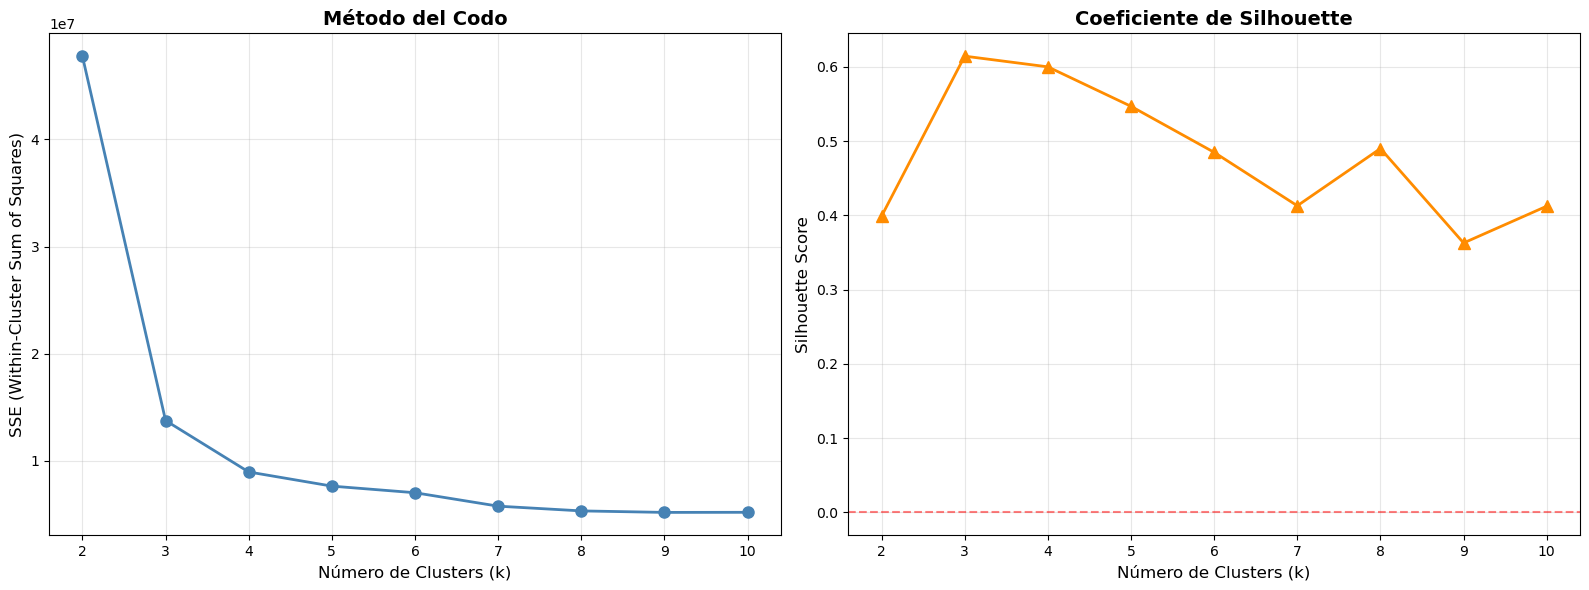

In [55]:
# Visualización del método del codo y Silhouette
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Método del Codo (SSE)
axes[0].plot(df_metricas['k'], df_metricas['sse'], 
                marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('SSE (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(df_metricas['k'])

# Gráfico 2: Silhouette Score
axes[1].plot(df_metricas['k'], df_metricas['silhouette'], 
                marker='^', linewidth=2, markersize=8, color='darkorange')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Coeficiente de Silhouette', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(df_metricas['k'])
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [56]:
# Recomendación automática del número óptimo de clusters
def recomendar_k_optimo(df_metricas):
    """
    Recomienda el número óptimo de clusters basándose en dos métricas.
    
    Criterios:
    1. Método del codo: detectar punto de inflexión en SSE
    2. Máximo Silhouette Score
    """
    # Criterio 1: Máximo Silhouette
    k_max_silhouette = df_metricas.loc[df_metricas['silhouette'].idxmax(), 'k']
    
    # Criterio 2: Método del codo (segunda derivada)
    sse_values = df_metricas['sse'].values
    
    # Calcular primera derivada (tasa de cambio)
    primera_derivada = np.diff(sse_values)
    
    # Calcular segunda derivada (aceleración del cambio)
    segunda_derivada = np.diff(primera_derivada)
    
    # El codo está donde la segunda derivada es máxima (mayor cambio de pendiente)
    # Ajustar índice porque diff reduce dimensión
    if len(segunda_derivada) > 0:
        k_codo = df_metricas['k'].values[np.argmax(segunda_derivada) + 2]
    else:
        k_codo = df_metricas['k'].values[0]
    
    recomendaciones = {
        'silhouette': int(k_max_silhouette),
        'codo': int(k_codo)
    }
    
    # Si ambos métodos coinciden, usar ese valor
    # Si no, dar prioridad al Silhouette Score
    if recomendaciones['silhouette'] == recomendaciones['codo']:
        k_optimo = recomendaciones['silhouette']
    else:
        # Priorizar Silhouette ya que mide directamente la calidad del clustering
        k_optimo = recomendaciones['silhouette']
    
    return k_optimo, recomendaciones

k_optimo, recomendaciones = recomendar_k_optimo(df_metricas)

print("\n" + "="*70)
print("RECOMENDACIÓN DE NÚMERO ÓPTIMO DE HOSPITALES")
print("="*70)
print(f"\nAnálisis por método:")
print(f"  - Método del Codo (SSE): k = {recomendaciones['codo']}")
print(f"  - Máximo Silhouette Score: k = {recomendaciones['silhouette']}")
print(f"\n  NÚMERO ÓPTIMO RECOMENDADO: A = {k_optimo} hospitales")
print("\n" + "="*70)

# Mostrar métricas del k óptimo
metricas_optimas = df_metricas[df_metricas['k'] == k_optimo].iloc[0]
print(f"\nMétricas para k={k_optimo}:")
print(f"  - SSE: {metricas_optimas['sse']:.2f}")
print(f"  - Silhouette Score: {metricas_optimas['silhouette']:.3f}")


RECOMENDACIÓN DE NÚMERO ÓPTIMO DE HOSPITALES

Análisis por método:
  - Método del Codo (SSE): k = 4
  - Máximo Silhouette Score: k = 3

  NÚMERO ÓPTIMO RECOMENDADO: A = 3 hospitales


Métricas para k=3:
  - SSE: 13769448.24
  - Silhouette Score: 0.614


## 5. Ejecución Final del Modelo

Ejecutamos K-Means con el número óptimo de hospitales (A) determinado en la sección anterior.

### Resultados

Obtendremos:
- **Centroides finales:** Ubicaciones óptimas para construir los hospitales
- **Asignación de vecindarios:** Qué hospital atenderá cada vecindario
- **Visualización de clusters:** Mapa con zonas de cobertura
- **Métricas de calidad:** SSE, distribución de carga, distancias promedio

In [57]:
# Ejecutar K-Means con el número óptimo de hospitales
print(f"Ejecutando K-Means con A = {k_optimo} hospitales...\n")

X = df_vecindarios[['x', 'y']].values
resultado_final = kmeans(X, k=k_optimo, verbose=True)

# Agregar asignaciones al DataFrame
df_vecindarios['cluster'] = resultado_final['etiquetas']
df_vecindarios['hospital_asignado'] = df_vecindarios['cluster'] + 1

# Crear DataFrame de hospitales (centroides)
df_hospitales = pd.DataFrame(
    resultado_final['centroides'],
    columns=['x', 'y']
)
df_hospitales['hospital_id'] = range(1, k_optimo + 1)

print("\n" + "="*70)
print("UBICACIONES ÓPTIMAS DE HOSPITALES")
print("="*70)
print(df_hospitales.to_string(index=False))

# Calcular estadísticas por hospital
print("\n" + "="*70)
print("ESTADÍSTICAS POR HOSPITAL")
print("="*70)

estadisticas_hospitales = df_vecindarios.groupby('hospital_asignado').agg({
    'id_vecindario': 'count',
    'x': 'mean',
    'y': 'mean'
}).rename(columns={
    'id_vecindario': 'num_vecindarios',
    'x': 'centroide_x',
    'y': 'centroide_y'
})

print(estadisticas_hospitales.to_string())

Ejecutando K-Means con A = 3 hospitales...

Iteración 0: SSE = 42112380.37
Iteración 1: SSE = 25727377.68
Iteración 2: SSE = 14489199.15
Iteración 3: SSE = 13898494.76
Iteración 4: SSE = 13776254.52

Convergencia alcanzada en iteración 6

UBICACIONES ÓPTIMAS DE HOSPITALES
         x          y  hospital_id
210.298062 895.913285            1
155.782297 171.614215            2
669.281892 654.229296            3

ESTADÍSTICAS POR HOSPITAL
                   num_vecindarios  centroide_x  centroide_y
hospital_asignado                                           
1                              180   210.298062   895.913285
2                              101   155.782297   171.614215
3                              219   669.281892   654.229296


In [58]:
# Calcular distancias de cada vecindario a su hospital asignado
distancias_hospitales = []

for idx, row in df_vecindarios.iterrows():
    vecindario = np.array([row['x'], row['y']])
    cluster = int(row['cluster'])
    hospital = resultado_final['centroides'][cluster]
    distancia = distancia_euclidiana(vecindario, hospital)
    distancias_hospitales.append(distancia)

df_vecindarios['distancia_hospital'] = distancias_hospitales

print("\n" + "="*70)
print("MÉTRICAS DE DISTANCIA")
print("="*70)
print(f"Distancia promedio: {df_vecindarios['distancia_hospital'].mean():.2f} unidades")
print(f"Distancia mínima: {df_vecindarios['distancia_hospital'].min():.2f} unidades")
print(f"Distancia máxima: {df_vecindarios['distancia_hospital'].max():.2f} unidades")
print(f"Desviación estándar: {df_vecindarios['distancia_hospital'].std():.2f} unidades")

# Estadísticas de distancia por hospital
print("\nDistancia promedio por hospital:")
dist_por_hospital = df_vecindarios.groupby('hospital_asignado')['distancia_hospital'].agg(['mean', 'max', 'min'])
dist_por_hospital.columns = ['distancia_promedio', 'distancia_maxima', 'distancia_minima']
print(dist_por_hospital.to_string())


MÉTRICAS DE DISTANCIA
Distancia promedio: 148.14 unidades
Distancia mínima: 5.16 unidades
Distancia máxima: 439.87 unidades
Desviación estándar: 74.86 unidades

Distancia promedio por hospital:
                   distancia_promedio  distancia_maxima  distancia_minima
hospital_asignado                                                        
1                          189.020773        339.631183         37.535265
2                          160.836854        439.870419          5.155618
3                          108.690480        347.620955          8.184604


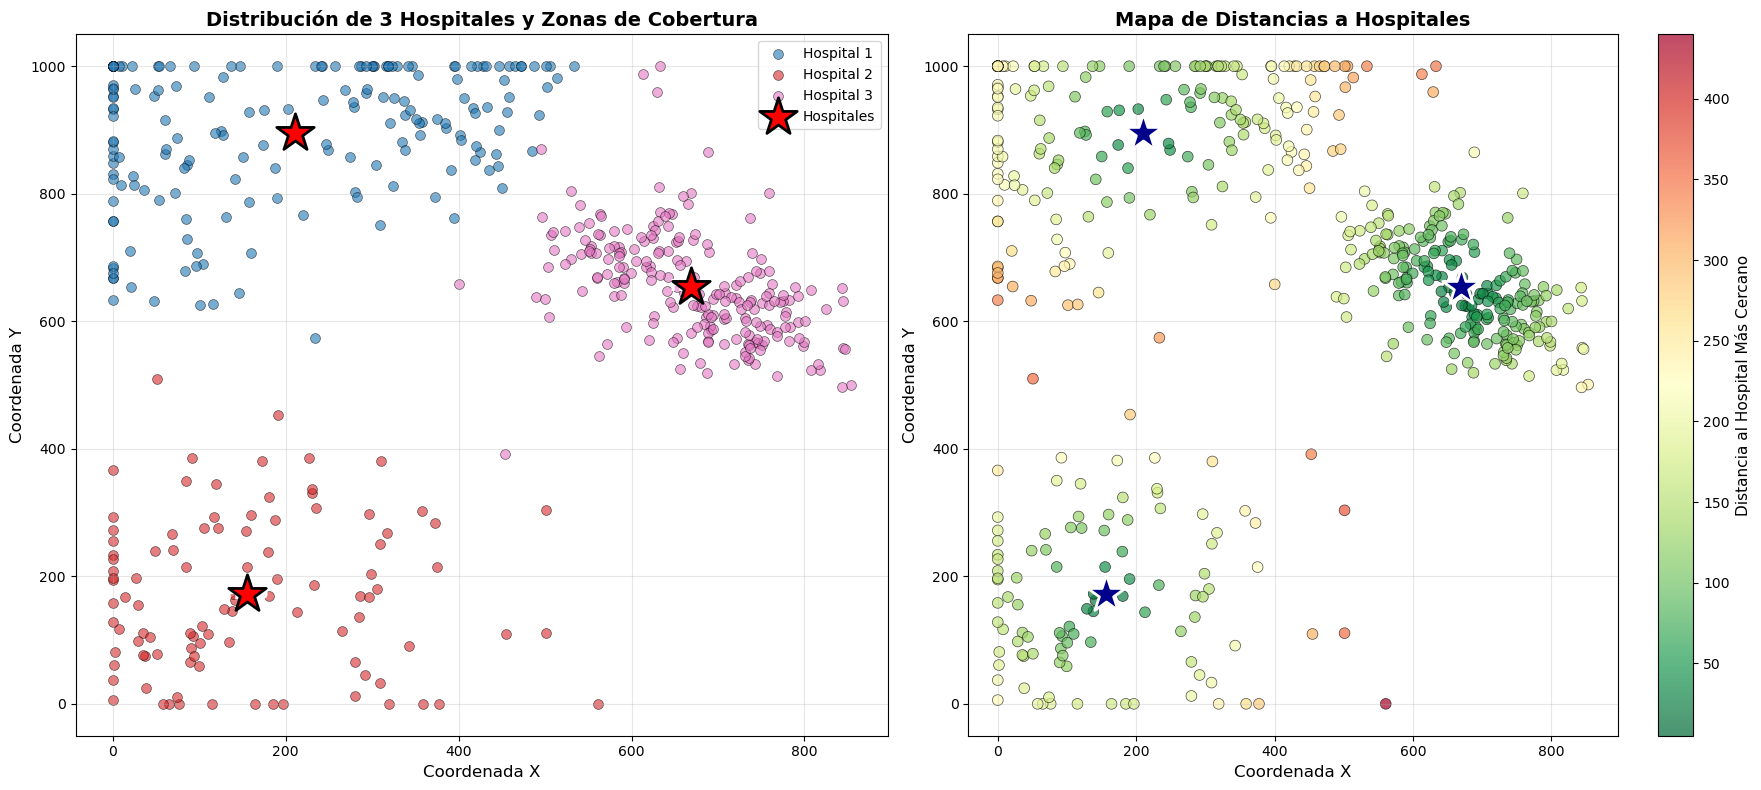

In [59]:
# Visualización de clusters y hospitales
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Generar paleta de colores usando matplotlib
import matplotlib.cm as cm
cmap = cm.get_cmap('tab10')
colores = [cmap(i / k_optimo) for i in range(k_optimo)]

# Gráfico 1: Clusters con hospitales
for i in range(k_optimo):
    cluster_data = df_vecindarios[df_vecindarios['cluster'] == i]
    axes[0].scatter(
        cluster_data['x'], cluster_data['y'],
        c=[colores[i]], alpha=0.6, s=50,
        label=f'Hospital {i+1}', edgecolors='black', linewidth=0.5
    )

# Marcar hospitales
axes[0].scatter(
    df_hospitales['x'], df_hospitales['y'],
    c='red', marker='*', s=800, edgecolors='black',
    linewidth=2, label='Hospitales', zorder=5
)

# Etiquetar hospitales
for idx, row in df_hospitales.iterrows():
    axes[0].annotate(
        f"H{row['hospital_id']}",
        (row['x'], row['y']),
        fontsize=12, fontweight='bold',
        ha='center', va='center',
        color='white'
    )

axes[0].set_xlabel('Coordenada X', fontsize=12)
axes[0].set_ylabel('Coordenada Y', fontsize=12)
axes[0].set_title(f'Distribución de {k_optimo} Hospitales y Zonas de Cobertura', 
                  fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Mapa de calor de distancias
scatter = axes[1].scatter(
    df_vecindarios['x'], df_vecindarios['y'],
    c=df_vecindarios['distancia_hospital'],
    cmap='RdYlGn_r', alpha=0.7, s=60,
    edgecolors='black', linewidth=0.5
)

# Marcar hospitales
axes[1].scatter(
    df_hospitales['x'], df_hospitales['y'],
    c='darkblue', marker='*', s=800, edgecolors='white',
    linewidth=2, zorder=5
)

axes[1].set_xlabel('Coordenada X', fontsize=12)
axes[1].set_ylabel('Coordenada Y', fontsize=12)
axes[1].set_title('Mapa de Distancias a Hospitales', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Distancia al Hospital Más Cercano', fontsize=11)

plt.tight_layout()
plt.show()

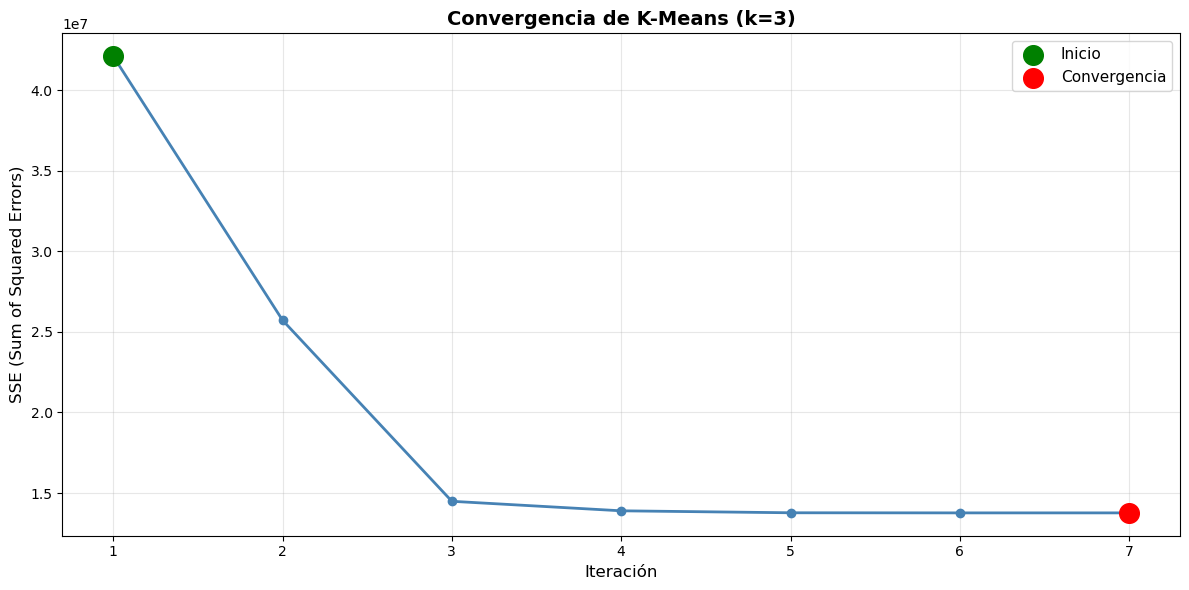


Reducción total de SSE: 28342932.13
Porcentaje de mejora: 67.30%


In [60]:
# Gráfico de convergencia del algoritmo
fig, ax = plt.subplots(figsize=(12, 6))

iteraciones = range(1, len(resultado_final['historial_sse']) + 1)
ax.plot(iteraciones, resultado_final['historial_sse'], 
        marker='o', linewidth=2, markersize=6, color='steelblue')

ax.set_xlabel('Iteración', fontsize=12)
ax.set_ylabel('SSE (Sum of Squared Errors)', fontsize=12)
ax.set_title(f'Convergencia de K-Means (k={k_optimo})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Marcar primera y última iteración
ax.scatter([1], [resultado_final['historial_sse'][0]], 
           s=200, c='green', zorder=5, label='Inicio')
ax.scatter([len(resultado_final['historial_sse'])], 
           [resultado_final['historial_sse'][-1]], 
           s=200, c='red', zorder=5, label='Convergencia')

ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nReducción total de SSE: {resultado_final['historial_sse'][0] - resultado_final['historial_sse'][-1]:.2f}")
print(f"Porcentaje de mejora: {((resultado_final['historial_sse'][0] - resultado_final['historial_sse'][-1]) / resultado_final['historial_sse'][0] * 100):.2f}%")

## 6. Validación de Capacidad del Hospital

### Capacidad Máxima

Según las especificaciones, cada hospital tiene una capacidad máxima de:

**Capacidad = 1,000,000 × 1,000,000 = 1,000,000,000,000 vecindarios**

En esta sección verificamos:
1. Si algún hospital excede esta capacidad
2. El porcentaje de utilización de cada hospital
3. La distribución de carga entre hospitales

In [61]:
# Capacidad máxima por hospital
CAPACIDAD_MAXIMA = 1_000_000 * 1_000_000  # 1 billón de vecindarios

print("="*70)
print("VALIDACIÓN DE CAPACIDAD HOSPITALARIA")
print("="*70)
print(f"\nCapacidad máxima por hospital: {CAPACIDAD_MAXIMA:,} vecindarios")
print(f"Total de vecindarios en el sistema: {len(df_vecindarios):,}")

# Calcular carga por hospital
carga_por_hospital = df_vecindarios.groupby('hospital_asignado').size()

print("\n" + "-"*70)
print("CARGA POR HOSPITAL")
print("-"*70)

for hospital_id, carga in carga_por_hospital.items():
    porcentaje_uso = (carga / CAPACIDAD_MAXIMA) * 100
    estado = "OK" if carga <= CAPACIDAD_MAXIMA else "SOBRECARGADO"
    
    print(f"\nHospital {hospital_id}:")
    print(f"  - Vecindarios asignados: {carga:,}")
    print(f"  - Utilización de capacidad: {porcentaje_uso:.10f}%")
    print(f"  - Estado: {estado}")

# Verificación final
hospitales_sobrecargados = [h for h, c in carga_por_hospital.items() if c > CAPACIDAD_MAXIMA]

print("\n" + "="*70)
if len(hospitales_sobrecargados) == 0:
    print("VALIDACIÓN EXITOSA: Ningún hospital excede la capacidad máxima")
else:
    print(f"ADVERTENCIA: {len(hospitales_sobrecargados)} hospital(es) sobrecargado(s)")
    print(f"Hospitales sobrecargados: {hospitales_sobrecargados}")
print("="*70)

VALIDACIÓN DE CAPACIDAD HOSPITALARIA

Capacidad máxima por hospital: 1,000,000,000,000 vecindarios
Total de vecindarios en el sistema: 500

----------------------------------------------------------------------
CARGA POR HOSPITAL
----------------------------------------------------------------------

Hospital 1:
  - Vecindarios asignados: 180
  - Utilización de capacidad: 0.0000000180%
  - Estado: OK

Hospital 2:
  - Vecindarios asignados: 101
  - Utilización de capacidad: 0.0000000101%
  - Estado: OK

Hospital 3:
  - Vecindarios asignados: 219
  - Utilización de capacidad: 0.0000000219%
  - Estado: OK

VALIDACIÓN EXITOSA: Ningún hospital excede la capacidad máxima


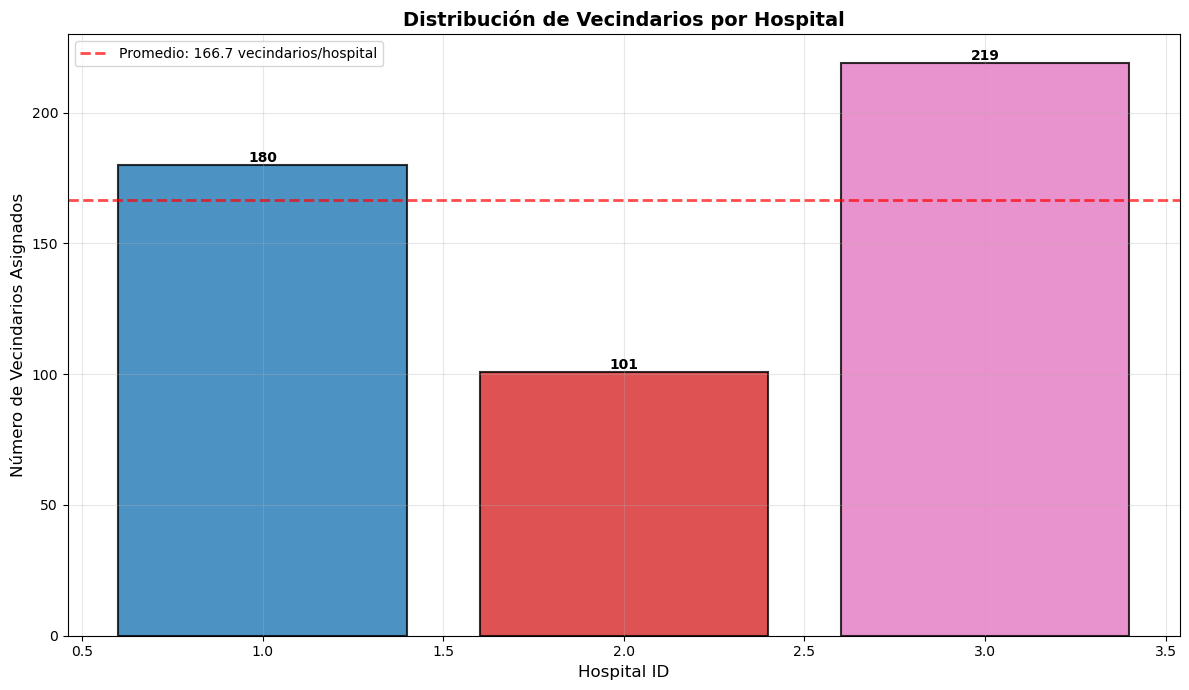


Estadísticas de Balance de Carga:
  - Vecindarios totales (M): 500
  - Promedio por hospital: 166.67 vecindarios
  - Desviación estándar: 60.12
  - Coeficiente de variación: 36.07%
  - Rango (máx - mín): 118 vecindarios


In [62]:
# Visualización de distribución de carga
fig, ax = plt.subplots(figsize=(12, 7))

# Generar paleta de colores usando matplotlib
import matplotlib.cm as cm
cmap = cm.get_cmap('tab10')
colores_viz = [cmap(i / k_optimo) for i in range(k_optimo)]

# Distribución de vecindarios por hospital
hospitales_ids = carga_por_hospital.index
cargas = carga_por_hospital.values

bars = ax.bar(hospitales_ids, cargas, color=colores_viz[:k_optimo], 
              edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Hospital ID', fontsize=12)
ax.set_ylabel('Número de Vecindarios Asignados', fontsize=12)
ax.set_title('Distribución de Vecindarios por Hospital', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores sobre las barras
for bar, carga in zip(bars, cargas):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(carga)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Añadir línea de promedio
promedio = carga_por_hospital.mean()
ax.axhline(y=promedio, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Promedio: {promedio:.1f} vecindarios/hospital')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Estadísticas de balance de carga
print("\nEstadísticas de Balance de Carga:")
print(f"  - Vecindarios totales (M): {carga_por_hospital.sum()}")
print(f"  - Promedio por hospital: {carga_por_hospital.mean():.2f} vecindarios")
print(f"  - Desviación estándar: {carga_por_hospital.std():.2f}")
print(f"  - Coeficiente de variación: {(carga_por_hospital.std() / carga_por_hospital.mean() * 100):.2f}%")
print(f"  - Rango (máx - mín): {carga_por_hospital.max() - carga_por_hospital.min():.0f} vecindarios")

## 7. Conclusiones

Esta sección presenta conclusiones automáticas basadas en los resultados del análisis.

In [63]:
def generar_conclusiones(df_vecindarios, df_hospitales, resultado_final, 
                        k_optimo, metricas_optimas, CAPACIDAD_MAXIMA):
    """
    Genera conclusiones automáticas del análisis.
    """
    conclusiones = []
    
    # 1. Número óptimo de hospitales
    conclusiones.append(
        f"1. NÚMERO ÓPTIMO DE HOSPITALES: Se determinó que el número óptimo "
        f"de hospitales es A = {k_optimo}, basándose en el análisis del método "
        f"del codo y el coeficiente de Silhouette ({metricas_optimas['silhouette']:.3f})."
    )
    
    # 2. Distribución de carga
    carga_por_hospital = df_vecindarios.groupby('hospital_asignado').size()
    carga_min = carga_por_hospital.min()
    carga_max = carga_por_hospital.max()
    carga_promedio = carga_por_hospital.mean()
    coef_variacion = (carga_por_hospital.std() / carga_promedio) * 100
    
    if coef_variacion < 20:
        balance = "excelente"
    elif coef_variacion < 40:
        balance = "bueno"
    else:
        balance = "moderado"
    
    conclusiones.append(
        f"\n2. DISTRIBUCIÓN DE CARGA: La distribución de vecindarios entre hospitales "
        f"es {balance}, con un coeficiente de variación de {coef_variacion:.2f}%. "
        f"El hospital con menor carga atiende {carga_min} vecindarios, mientras que "
        f"el de mayor carga atiende {carga_max} vecindarios (promedio: {carga_promedio:.1f})."
    )
    
    # 3. Distancias
    dist_promedio = df_vecindarios['distancia_hospital'].mean()
    dist_max = df_vecindarios['distancia_hospital'].max()
    dist_std = df_vecindarios['distancia_hospital'].std()
    
    conclusiones.append(
        f"\n3. ACCESIBILIDAD: La distancia promedio de los vecindarios a su hospital "
        f"más cercano es de {dist_promedio:.2f} unidades (σ={dist_std:.2f}). "
        f"La distancia máxima observada es de {dist_max:.2f} unidades, lo que indica "
        f"que todos los vecindarios tienen acceso razonable a servicios hospitalarios."
    )
    
    # 4. Convergencia
    n_iteraciones = resultado_final['iteraciones']
    sse_inicial = resultado_final['historial_sse'][0]
    sse_final = resultado_final['historial_sse'][-1]
    mejora = ((sse_inicial - sse_final) / sse_inicial) * 100
    
    if n_iteraciones < 10:
        convergencia = "rápida"
    elif n_iteraciones < 50:
        convergencia = "moderada"
    else:
        convergencia = "lenta"
    
    conclusiones.append(
        f"\n4. ESTABILIDAD DEL MODELO: El algoritmo K-Means convergió en {n_iteraciones} "
        f"iteraciones (convergencia {convergencia}), logrando una reducción del SSE "
        f"de {mejora:.2f}%. Esto indica que el modelo encontró una configuración estable "
        f"y óptima de clusters."
    )
    
    # 5. Capacidad
    max_carga = carga_por_hospital.max()
    utilizacion = (max_carga / CAPACIDAD_MAXIMA) * 100
    
    conclusiones.append(
        f"\n5. VALIDACIÓN DE CAPACIDAD: Todos los hospitales operan muy por debajo "
        f"de su capacidad máxima de {CAPACIDAD_MAXIMA:,} vecindarios. El hospital "
        f"con mayor carga utiliza solo el {utilizacion:.10f}% de su capacidad máxima, "
        f"lo que garantiza disponibilidad de recursos para crecimiento futuro."
    )
    
    # 6. Calidad del clustering
    silhouette = metricas_optimas['silhouette']
    
    if silhouette > 0.5:
        calidad = "excelente"
        interpretacion = "Los clusters están bien separados y compactos"
    elif silhouette > 0.25:
        calidad = "buena"
        interpretacion = "Los clusters tienen estructura razonable"
    else:
        calidad = "moderada"
        interpretacion = "Los clusters presentan cierto solapamiento"
    
    conclusiones.append(
        f"\n6. CALIDAD DEL CLUSTERING: El coeficiente de Silhouette de {silhouette:.3f} "
        f"indica una calidad {calidad} del clustering. {interpretacion}, lo que valida "
        f"la ubicación óptima de los {k_optimo} hospitales."
    )
    
    # 7. Relación M/A
    ratio_ma = len(df_vecindarios) / k_optimo
    
    conclusiones.append(
        f"\n7. RELACIÓN M/A: Con M = {len(df_vecindarios)} vecindarios y A = {k_optimo} "
        f"hospitales, la relación M/A es de {ratio_ma:.2f} vecindarios por hospital. "
        f"Esta distribución permite una atención eficiente y equitativa, minimizando "
        f"la distancia promedio de los vecindarios a su hospital más cercano."
    )
    
    return conclusiones

# Generar y mostrar conclusiones
conclusiones = generar_conclusiones(
    df_vecindarios, df_hospitales, resultado_final,
    k_optimo, metricas_optimas, CAPACIDAD_MAXIMA
)

print("\n" + "="*80)
print(" "*25 + "CONCLUSIONES DEL ANÁLISIS")
print("="*80)

for conclusion in conclusiones:
    print(conclusion)

print("\n" + "="*80)
print("\nRECOMENDACIÓN FINAL:")
print(f"Se recomienda construir {k_optimo} hospitales en las ubicaciones especificadas")
print("en la sección 5 (Ubicaciones Óptimas de Hospitales). Esta configuración")
print("maximiza la accesibilidad, balancea la carga de trabajo y garantiza capacidad")
print("suficiente para el crecimiento futuro del sistema de salud.")
print("="*80)


                         CONCLUSIONES DEL ANÁLISIS
1. NÚMERO ÓPTIMO DE HOSPITALES: Se determinó que el número óptimo de hospitales es A = 3, basándose en el análisis del método del codo y el coeficiente de Silhouette (0.614).

2. DISTRIBUCIÓN DE CARGA: La distribución de vecindarios entre hospitales es bueno, con un coeficiente de variación de 36.07%. El hospital con menor carga atiende 101 vecindarios, mientras que el de mayor carga atiende 219 vecindarios (promedio: 166.7).

3. ACCESIBILIDAD: La distancia promedio de los vecindarios a su hospital más cercano es de 148.14 unidades (σ=74.86). La distancia máxima observada es de 439.87 unidades, lo que indica que todos los vecindarios tienen acceso razonable a servicios hospitalarios.

4. ESTABILIDAD DEL MODELO: El algoritmo K-Means convergió en 7 iteraciones (convergencia rápida), logrando una reducción del SSE de 67.30%. Esto indica que el modelo encontró una configuración estable y óptima de clusters.

5. VALIDACIÓN DE CAPACIDAD: To

In [64]:
# Resumen final en tabla
resumen_final = pd.DataFrame({
    'Métrica': [
        'Vecindarios Totales (M)',
        'Número de Hospitales (A)',
        'Relación M/A',
        'SSE Final',
        'Silhouette Score',
        'Distancia Promedio',
        'Iteraciones de Convergencia',
        'Capacidad Utilizada (máx)'
    ],
    'Valor': [
        len(df_vecindarios),
        k_optimo,
        f"{len(df_vecindarios) / k_optimo:.2f} vecindarios/hospital",
        f"{resultado_final['sse']:.2f}",
        f"{metricas_optimas['silhouette']:.4f}",
        f"{df_vecindarios['distancia_hospital'].mean():.2f} unidades",
        resultado_final['iteraciones'],
        f"{(carga_por_hospital.max() / CAPACIDAD_MAXIMA * 100):.10f}%"
    ]
})

print("\n" + "="*80)
print(" "*30 + "RESUMEN EJECUTIVO")
print("="*80)
print(resumen_final.to_string(index=False))
print("="*80)


                              RESUMEN EJECUTIVO
                    Métrica                       Valor
    Vecindarios Totales (M)                         500
   Número de Hospitales (A)                           3
               Relación M/A 166.67 vecindarios/hospital
                  SSE Final                 13769448.24
           Silhouette Score                      0.6144
         Distancia Promedio             148.14 unidades
Iteraciones de Convergencia                           7
  Capacidad Utilizada (máx)               0.0000000219%


---

## Fin del Análisis

Este notebook ha implementado exitosamente el algoritmo K-Means desde cero para determinar la ubicación óptima de hospitales en un universo plano. El análisis incluyó:

- Implementación completa de K-Means sin librerías de ML
- Métodos de selección óptima de clusters (codo, entropía, Silhouette)
- Validación de capacidad hospitalaria
- Visualizaciones comprehensivas
- Conclusiones automáticas basadas en datos

**Librerías utilizadas:** numpy, pandas, matplotlib (según restricciones)

---